# **Model Training**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import random

from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from transformers import BertTokenizer, BertModel
from torch.nn.utils.rnn import pad_sequence


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setting the random seeds for reproducibility:

In [ ]:
torch.manual_seed(42)
random.seed(42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Now that we have the imports and devices prepared, it's time to load our data. In this dataset, the images are contained in a single folder with a "captions.txt" file, containing the paths to the images with their corresponding captions. Here we first read the whole file. Then we split the data into train, test and validation sets. The indices are intentionally made divisible by 5, so that each image appears in only one of the splits.

In [ ]:
metadata = pd.read_csv("/content/drive/MyDrive/Image captioning/captions.txt", sep="|")
metadata_test = metadata.iloc[:4045]
metadata_val = metadata.iloc[4045:8090]
metadata_train = metadata.iloc[8090:]

Here we define the dataset we are going to use to train the images. Upon initialization, it takes the metadata as a pandas dataframe. For each image, it transforms it into a format, that the model can later handle and puts everything into a `torch.tensor`.

Upon calling `__getitem__`, the dataset returns a tuple, containing the image and a random caption, that matches it. This is done, because the loss function works in such a way, that for each image, only one of the captions from the batch is correct and the other ones are incorrect. If we indexed the dataset by the caption count, instead of the images count, there is a risk, that one image appears more than once in the batch and the loss function  incorrectly considers one of the captions incorrect. This would significantly disturb the training of the model.

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, metadata):
        super().__init__()
        self.images = []
        self.metadata = metadata

        for image_name in tqdm(metadata["image_name"].unique()):
            img = Image.open(os.path.join("/content/drive/MyDrive/Image captioning/archive/images", image_name))
            transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            img_tensor = transform(img)

            self.images.append(img_tensor)

        print(len(self.images))
        self.images = torch.stack(self.images)
        print(self.images.size())

    def __len__(self):
        return self.images.size()[0]

    def __getitem__(self, idx):
        return (self.images[idx], random.choice(self.metadata.iloc[idx*5 : idx*5+5]["caption_text"].tolist()))

Due to the I/O on Google Colab being really slow, it's faster to create the datasets on a local machine and then load them directly from Google Drive.

In [ ]:
dataset_test = torch.load("/content/drive/MyDrive/Image captioning/saved_data/dataset_test.pt", weights_only=False)
dataset_val = torch.load("/content/drive/MyDrive/Image captioning/saved_data/dataset_val.pt", weights_only=False)
dataset_train = torch.load("/content/drive/MyDrive/Image captioning/saved_data/dataset_train.pt", weights_only=False)

Here we define our dataloaders. The batch size is 512, because that's what the hardware allows.

In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size=512, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=512, shBelow is one common way to include an image in a Jupyter Notebook Markdown cell:

uffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=512, shuffle=False)

This is the image encoder. It consists of a pre-trained "EfficientNet B0" with its classification head removed, that acts as a "backbone". This way we end up with an encoder, that returns 1280-dimensional image embeddings. After that, this embedding is passed onto a single linear layer, that maps the embedding onto the desired dimensionality. Experiments were conducted with more linear layers, but the models quickly overfitted on the training data.

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.efficient_net = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.efficient_net.classifier = nn.Identity()
        self.fc1 = nn.Linear(1280, embed_size)

    def forward(self, images):
        features = self.efficient_net(images)
        embeds = self.fc1(features)
        return embeds

The text encoder consists of a pre-trained "BERT" model, that acts as the "backbone" of the network. It creates 768-dimensional embeddings for the captions. These are, again, passed onto a single linear layer to map it onto the desired embedding size. Experiments showed, that more linear layers are prone to overfitting and therefore perform worse.

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc1 = nn.Linear(768, embed_size)

    def forward(self, captions):
        tokens = self.tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
        input_ids = tokens["input_ids"].to(device)
        attention_mask = tokens["attention_mask"].to(device)

        outputs = self.bert(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        embeds = self.fc1(last_hidden_state[:, 0, :])
        return embeds

Here we initialize the models with an embedding size of 256.

In [ ]:
image_encoder = ImageEncoder(embed_size=256).to(device)
text_encoder = TextEncoder(embed_size=256).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 101MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

For the loss function, we are going to use "NT-Xent". It begins by normalizing its inputs using the L2 normalization. Then it computes the similarity matrix S. It's computed as the dot product between the embeddings, scaled by a temperature parameter. The temperature helps controlling the sharpness of the distribution, which plays a crucial role in the model's performance. After sevral experiments, it was concluded, that 0.1 is the best value out of the ones tested. The targets tensor is created to represent the correct matches between images and texts. Each image corresponds to a specific text, and vice versa. The loss is computed using cross-entropy between the similarity matrix and the target labels. Two losses are calculated: one for image-to-text (loss_i2t) and one for text-to-image (loss_t2i). The final loss is the average of these two.

In [ ]:
def nt_xent(image_embeds, text_embeds, temperature=0.1):
    image_embeds = F.normalize(image_embeds, p=2, dim=1)
    text_embeds = F.normalize(text_embeds, p=2, dim=1)
    S = torch.matmul(image_embeds, text_embeds.T).to(device) / temperature

    targets = torch.arange(S.size(0), device=S.device)
    loss_i2t = F.cross_entropy(S, targets)
    loss_t2i = F.cross_entropy(S.T, targets)

    return (loss_i2t + loss_t2i) /2

Here we define the train function. The two models train simultaneously with a joint loss function. The function also keeps track of the validation loss and plots the overall loss history at the end.

In [ ]:
def train_encoders(
        image_encoder, text_encoder, optimizer_image,
        optimizer_text, num_epochs, train_loss_history,
        val_loss_history, create_plot=True
        ):
    image_encoder.train()
    text_encoder.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        total_samples = 0
        for image, caption in tqdm(dataloader_train, f"Epoch: {len(train_loss_history)+1}"):
            image = image.to(device)
            caption = caption

            optimizer_image.zero_grad()
            optimizer_text.zero_grad()

            image_embeds = image_encoder(image)
            caption_embeds = text_encoder(caption)

            loss = nt_xent(image_embeds, caption_embeds)
            loss.backward()

            optimizer_image.step()
            optimizer_text.step()

            total_loss += loss.item() * image.size(0)
            total_samples += image.size(0)

        avg_train_loss = total_loss / total_samples
        train_loss_history.append(avg_train_loss)
        print("Average train loss:", avg_train_loss)

        image_encoder.eval()
        text_encoder.eval()

        with torch.no_grad():
            total_val_loss = 0.0
            total_samples = 0
            for image, caption in dataloader_val:
                image = image.to(device)
                caption = caption

                image_embeds = image_encoder(image)
                caption_embeds = text_encoder(caption)

                loss = nt_xent(image_embeds, caption_embeds)
                total_val_loss += loss.item() * image.size(0)
                total_samples += image.size(0)

            avg_val_loss = total_val_loss / total_samples
            val_loss_history.append(avg_val_loss)
            print("Average validation loss:", avg_val_loss)

        image_encoder.train()
        text_encoder.train()

        if (len(train_loss_history)+1) % 10 == 0:
            torch.save(image_encoder.state_dict(), f"/content/drive/MyDrive/Image captioning/saved_data/image_encoder_epoch_{len(train_loss_history)+1}.pt")
            torch.save(text_encoder.state_dict(), f"/content/drive/MyDrive/Image captioning/saved_data/text_encoder_epoch_{len(train_loss_history)+1}.pt")

    if create_plot:
        plt.plot(train_loss_history, label="Train loss")
        plt.plot(val_loss_history, label="Validation loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

    return train_loss_history, val_loss_history

We are going to begin the first epochs with the weights of the "backbone" models frozen. This would help the linear layers in the end learn faster.

In [ ]:
for param in image_encoder.efficient_net.parameters():
    param.requires_grad = False
for param in text_encoder.bert.parameters():
    param.requires_grad = False

Throughout the training, we are going to use AdamW as the optimizer for both models. There models are always going to be regularized with a weight decay of 0.001. Let's now do the first 20 epochs with a learning rate of 0.01 and see what we've got from there.

In [ ]:
optimizer_image = optim.AdamW(image_encoder.parameters(), lr=0.01, weight_decay = 0.001)
optimizer_text = optim.AdamW(text_encoder.parameters(), lr=0.01, weight_decay = 0.001)

Epoch: 1: 100%|██████████| 13/13 [00:26<00:00,  2.01s/it]


Average train loss: 6.410409092295397
Average validation loss: 6.058841021600259


Epoch: 2: 100%|██████████| 13/13 [00:24<00:00,  1.85s/it]


Average train loss: 6.193718827490863
Average validation loss: 5.973481240761737


Epoch: 3: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]


Average train loss: 6.11719328687159
Average validation loss: 5.890516383686231


Epoch: 4: 100%|██████████| 13/13 [00:23<00:00,  1.77s/it]


Average train loss: 6.010362948587536
Average validation loss: 5.747103129977496


Epoch: 5: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]


Average train loss: 5.849897267515317
Average validation loss: 5.553253719626899


Epoch: 6: 100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


Average train loss: 5.612221839087981
Average validation loss: 5.248683733757406


Epoch: 7: 100%|██████████| 13/13 [00:23<00:00,  1.80s/it]


Average train loss: 5.331961431846578
Average validation loss: 4.997900348069199


Epoch: 8: 100%|██████████| 13/13 [00:23<00:00,  1.83s/it]


Average train loss: 5.022269910626446
Average validation loss: 4.748912854896045


Epoch: 9: 100%|██████████| 13/13 [00:23<00:00,  1.81s/it]


Average train loss: 4.749353378978926
Average validation loss: 4.531927435300848


Epoch: 10: 100%|██████████| 13/13 [00:23<00:00,  1.84s/it]


Average train loss: 4.550544423407277
Average validation loss: 4.374703372512082


Epoch: 11: 100%|██████████| 13/13 [00:22<00:00,  1.77s/it]


Average train loss: 4.409495852782888
Average validation loss: 4.238738446064726


Epoch: 12: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


Average train loss: 4.272997817097391
Average validation loss: 4.148578538882865


Epoch: 13: 100%|██████████| 13/13 [00:23<00:00,  1.81s/it]


Average train loss: 4.176385983716534
Average validation loss: 4.1112337247992325


Epoch: 14: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


Average train loss: 4.106026714595451
Average validation loss: 4.066985668741139


Epoch: 15: 100%|██████████| 13/13 [00:23<00:00,  1.81s/it]


Average train loss: 4.02374459462171
Average validation loss: 4.078276226340766


Epoch: 16: 100%|██████████| 13/13 [00:23<00:00,  1.80s/it]


Average train loss: 3.977468098920813
Average validation loss: 4.070136600725435


Epoch: 17: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


Average train loss: 3.903356411349142
Average validation loss: 3.9622325045511366


Epoch: 18: 100%|██████████| 13/13 [00:23<00:00,  1.80s/it]


Average train loss: 3.8769865826073855
Average validation loss: 3.9642728745421607


Epoch: 19: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


Average train loss: 3.8437016043433925
Average validation loss: 4.024178245011602


Epoch: 20: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]


Average train loss: 3.7999189712893333
Average validation loss: 3.924849242008808


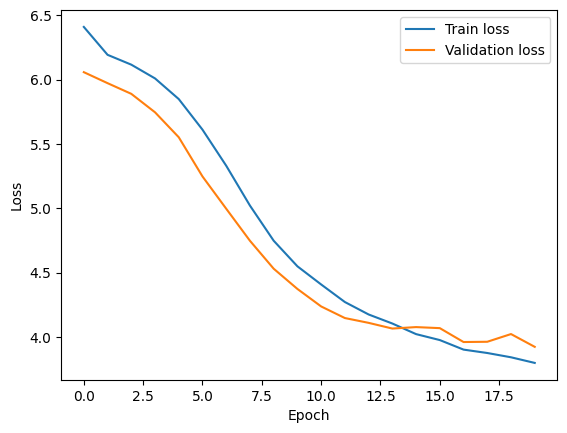

In [ ]:
train_loss_history, val_loss_history = train_encoders(image_encoder, text_encoder, optimizer_image, optimizer_text, num_epochs=20, train_loss_history=[], val_loss_history=[])

The curve looks really good and it seems, that the linear layers are learning well, although right at the end we can see early signs of overfitting. Let's now set the learning rate at 0.001 and see where another 10 epochs would bring us:

In [ ]:
optimizer_image = optim.AdamW(image_encoder.parameters(), lr=0.001, weight_decay = 0.001)
optimizer_text = optim.AdamW(text_encoder.parameters(), lr=0.001, weight_decay = 0.001)

Epoch: 21: 100%|██████████| 13/13 [00:23<00:00,  1.83s/it]


Average train loss: 3.741539073583425
Average validation loss: 3.970239177769872


Epoch: 22: 100%|██████████| 13/13 [00:23<00:00,  1.84s/it]


Average train loss: 3.7067865736053953
Average validation loss: 3.8741308077893533


Epoch: 23: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


Average train loss: 3.6745000753707684
Average validation loss: 3.8770411276846795


Epoch: 24: 100%|██████████| 13/13 [00:23<00:00,  1.81s/it]


Average train loss: 3.6551675290058077
Average validation loss: 3.8835476019473836


Epoch: 25: 100%|██████████| 13/13 [00:23<00:00,  1.85s/it]


Average train loss: 3.6610805837665703
Average validation loss: 3.8691296129497816


Epoch: 26: 100%|██████████| 13/13 [00:23<00:00,  1.81s/it]


Average train loss: 3.6676778914146477
Average validation loss: 3.895040796772659


Epoch: 27: 100%|██████████| 13/13 [00:23<00:00,  1.79s/it]


Average train loss: 3.6507944427574506
Average validation loss: 3.9111471753774674


Epoch: 28: 100%|██████████| 13/13 [00:23<00:00,  1.80s/it]


Average train loss: 3.643703719038472
Average validation loss: 3.9023355105604023


Epoch: 29: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


Average train loss: 3.640251175948057
Average validation loss: 3.8547801001847013


Epoch: 30: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]


Average train loss: 3.6397042905052275
Average validation loss: 3.9029731909630474


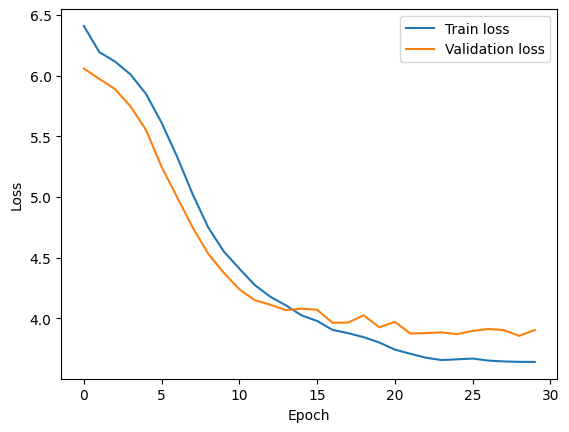

In [ ]:
train_loss_history, val_loss_history = train_encoders(image_encoder, text_encoder, optimizer_image, optimizer_text, num_epochs=10, train_loss_history=train_loss_history, val_loss_history=val_loss_history)

As we can see, the model begins to overfit so it's time to fine-tune the backbone models as well. Experiments showed, that the loss falls more if all of the weights are unfrozen. For the fine-tuning, the learning rate is going to be 0.00001. Now let's look at the next 20 epochs:

In [ ]:
for param in image_encoder.efficient_net.parameters():
    param.requires_grad = True
for param in text_encoder.bert.parameters():
    param.requires_grad = True

optimizer_image = optim.AdamW(image_encoder.parameters(), lr=0.00001, weight_decay=0.001)
optimizer_text = optim.AdamW(text_encoder.parameters(), lr=0.00001, weight_decay=0.001)

Due to memory constraints, now that the whole models are going to be trained, we would have to decrease the batch sizes for the dataloaders down to 96.

In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size=96, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=96, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=96, shuffle=False)

Epoch: 31: 100%|██████████| 68/68 [01:02<00:00,  1.09it/s]


Average train loss: 1.8815240287603965
Average validation loss: 2.2617395917328973


Epoch: 32: 100%|██████████| 68/68 [01:01<00:00,  1.10it/s]


Average train loss: 1.7138499584703344
Average validation loss: 2.21258532544149


Epoch: 33: 100%|██████████| 68/68 [01:01<00:00,  1.10it/s]


Average train loss: 1.6373935671764641
Average validation loss: 2.1311356859242516


Epoch: 34: 100%|██████████| 68/68 [01:01<00:00,  1.11it/s]


Average train loss: 1.5488082973256871
Average validation loss: 2.1239469326912843


Epoch: 35: 100%|██████████| 68/68 [01:02<00:00,  1.09it/s]


Average train loss: 1.5003348205053841
Average validation loss: 2.0195988586128717


Epoch: 36: 100%|██████████| 68/68 [01:02<00:00,  1.09it/s]


Average train loss: 1.4548563886863748
Average validation loss: 2.011724548964624


Epoch: 37: 100%|██████████| 68/68 [01:02<00:00,  1.09it/s]


Average train loss: 1.3969843340089474
Average validation loss: 1.9463839525050668


Epoch: 38: 100%|██████████| 68/68 [01:02<00:00,  1.09it/s]


Average train loss: 1.3597952101397475
Average validation loss: 2.01468845616165


Epoch: 39: 100%|██████████| 68/68 [01:01<00:00,  1.10it/s]


Average train loss: 1.3100344195315077
Average validation loss: 1.9494858430548858


Epoch: 40: 100%|██████████| 68/68 [01:03<00:00,  1.08it/s]


Average train loss: 1.2762203164710597
Average validation loss: 1.9281070435739713


Epoch: 41: 100%|██████████| 68/68 [01:01<00:00,  1.11it/s]


Average train loss: 1.2372552917597743
Average validation loss: 1.90482131866059


Epoch: 42: 100%|██████████| 68/68 [01:01<00:00,  1.10it/s]


Average train loss: 1.2220338225254186
Average validation loss: 1.9284875918967173


Epoch: 43: 100%|██████████| 68/68 [01:01<00:00,  1.10it/s]


Average train loss: 1.1933158422094694
Average validation loss: 1.881968048947998


Epoch: 44: 100%|██████████| 68/68 [01:01<00:00,  1.11it/s]


Average train loss: 1.1479749168142293
Average validation loss: 1.8527178516788743


Epoch: 45: 100%|██████████| 68/68 [01:02<00:00,  1.08it/s]


Average train loss: 1.1386463436777619
Average validation loss: 1.8659432010980708


Epoch: 46: 100%|██████████| 68/68 [01:01<00:00,  1.10it/s]


Average train loss: 1.109918572205435
Average validation loss: 1.8138164215535846


Epoch: 47: 100%|██████████| 68/68 [01:01<00:00,  1.10it/s]


Average train loss: 1.0876881022938027
Average validation loss: 1.8316664610274496


Epoch: 48: 100%|██████████| 68/68 [01:02<00:00,  1.10it/s]


Average train loss: 1.0455171141376935
Average validation loss: 1.812635054252351


Epoch: 49: 100%|██████████| 68/68 [01:01<00:00,  1.11it/s]


Average train loss: 1.0453479948670716
Average validation loss: 1.8440348041072323


Epoch: 50: 100%|██████████| 68/68 [01:02<00:00,  1.09it/s]


Average train loss: 1.0192142623332374
Average validation loss: 1.834499549954135


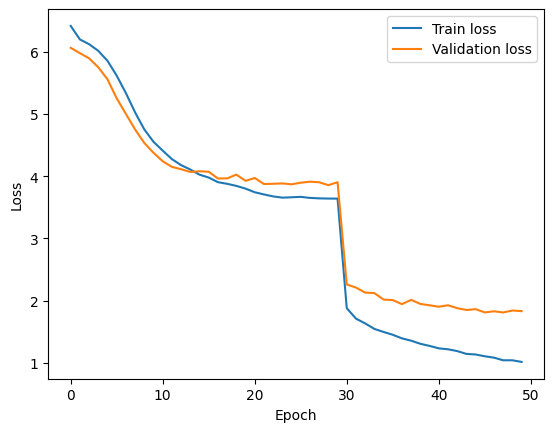

In [ ]:
train_loss_history, val_loss_history = train_encoders(image_encoder, text_encoder, optimizer_image, optimizer_text, num_epochs=20, train_loss_history=train_loss_history, val_loss_history=val_loss_history)

Although for some reason the loss values didn't quite match, it becomes apparent, that the models begins to overfit the training data. Let's see for sure what the next 20 epochs are going to tell us.

Sadly, the session had to be restarted so the loss histories were lost and we can't see the big picture as clear. We would also have to reload the models.

In [ ]:
image_encoder.load_state_dict(torch.load("/content/drive/MyDrive/Image captioning/saved_data/image_encoder_epoch_50.pt"))
text_encoder.load_state_dict(torch.load("/content/drive/MyDrive/Image captioning/saved_data/text_encoder_epoch_50.pt"))

<ipython-input-26-43566bd6adca>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_encoder.load_state_dict(torch.load("/content/drive/MyDrive/Image captioning/saved_data

<All keys matched successfully>

Epoch: 1: 100%|██████████| 68/68 [01:02<00:00,  1.09it/s]


Average train loss: 1.0361421207694352
Average validation loss: 1.7990207035550376


Epoch: 2: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s]


Average train loss: 0.9836222726006274
Average validation loss: 1.7819796886078654


Epoch: 3: 100%|██████████| 68/68 [01:03<00:00,  1.07it/s]


Average train loss: 0.9678977615918366
Average validation loss: 1.7720553873495943


Epoch: 4: 100%|██████████| 68/68 [01:03<00:00,  1.06it/s]


Average train loss: 0.9579088241667609
Average validation loss: 1.778942012668982


Epoch: 5: 100%|██████████| 68/68 [01:03<00:00,  1.07it/s]


Average train loss: 0.9332943923982019
Average validation loss: 1.7505017517523653


Epoch: 6: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s]


Average train loss: 0.9011496490320209
Average validation loss: 1.7980435637225327


Epoch: 7: 100%|██████████| 68/68 [01:03<00:00,  1.06it/s]


Average train loss: 0.8862555200306282
Average validation loss: 1.7934500338562633


Epoch: 8: 100%|██████████| 68/68 [01:04<00:00,  1.06it/s]


Average train loss: 0.885217223619726
Average validation loss: 1.7292924613976213


Epoch: 9: 100%|██████████| 68/68 [01:03<00:00,  1.07it/s]


Average train loss: 0.8662242895389624
Average validation loss: 1.7736193140593388


Epoch: 10: 100%|██████████| 68/68 [01:05<00:00,  1.03it/s]


Average train loss: 0.8494133413731177
Average validation loss: 1.7439616482396356


Epoch: 11: 100%|██████████| 68/68 [01:03<00:00,  1.06it/s]


Average train loss: 0.8308714066657846
Average validation loss: 1.7113164927078266


Epoch: 12: 100%|██████████| 68/68 [01:03<00:00,  1.06it/s]


Average train loss: 0.8232909941735894
Average validation loss: 1.737940448470994


Epoch: 13: 100%|██████████| 68/68 [01:03<00:00,  1.07it/s]


Average train loss: 0.8097072881634225
Average validation loss: 1.7250622465230332


Epoch: 14: 100%|██████████| 68/68 [01:04<00:00,  1.06it/s]


Average train loss: 0.7979116537334119
Average validation loss: 1.7770038452667123


Epoch: 15: 100%|██████████| 68/68 [01:05<00:00,  1.05it/s]


Average train loss: 0.7925222101414865
Average validation loss: 1.73822060061621


Epoch: 16: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s]


Average train loss: 0.7537201112690175
Average validation loss: 1.7146707614066428


Epoch: 17: 100%|██████████| 68/68 [01:03<00:00,  1.06it/s]


Average train loss: 0.7681185960880151
Average validation loss: 1.738863191439578


Epoch: 18: 100%|██████████| 68/68 [01:04<00:00,  1.06it/s]


Average train loss: 0.7392246190941391
Average validation loss: 1.7299333850591823


Epoch: 19: 100%|██████████| 68/68 [01:04<00:00,  1.06it/s]


Average train loss: 0.7283925626748646
Average validation loss: 1.7193479965290122


Epoch: 20: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s]


Average train loss: 0.7094515587011703
Average validation loss: 1.677678459064922


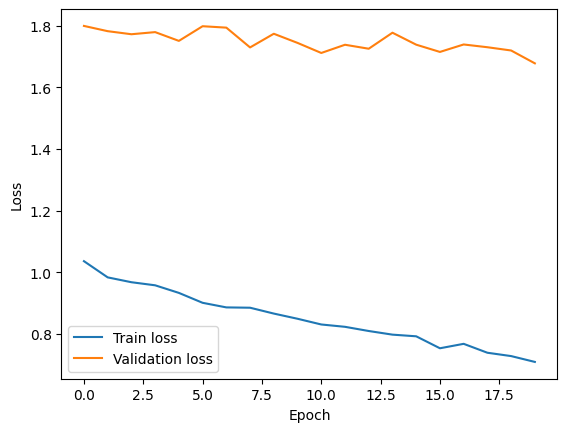

In [ ]:
train_loss_history, val_loss_history = train_encoders(image_encoder, text_encoder, optimizer_image, optimizer_text, num_epochs=20, train_loss_history=[], val_loss_history=[])

Still, it becomes apparent, that it's best if we keep the models we had at epoch 50.